In [125]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px
import numpy as np
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import GridSearchCV #probar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.model_selection import cross_validate

from sklearn.metrics import plot_roc_curve, auc, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasClassifier

np.random.seed(777)

In [126]:
data_dir = 'data'

In [127]:
def over_sampling(X: np.array, y: np.array) -> tuple:
  sm = SMOTE(random_state = 42)
  return sm.fit_resample(X, y)

def outlier(X: np.array) -> list:
  clf    = LocalOutlierFactor(n_neighbors=20)
  yhat   = clf.fit_predict(X)
  mask   = yhat != -1
  return mask

def get_name_clf(clf):
    return clf.__class__.__name__

def neuronal_network(n_features: int):
    clf = Sequential()
    clf.add(Dense(32, activation='relu', input_dim = n_features))
    clf.add(Dense(64, activation='relu'))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=["accuracy"])
    return clf

def print_measure(model: dict):
  print("%s\n\tscore_train: %.3f | score_test: %.3f" %(model["name"],model["AUC_train"], model["AUC_test"]))

In [128]:
classifiers = [
  LogisticRegression(),
  GaussianNB(),
  KNeighborsClassifier(11),
  SVC(kernel="rbf", C=0.025, probability=True),
  NuSVC(probability=True),
  DecisionTreeClassifier(),
  RandomForestClassifier(),
  AdaBoostClassifier(),
  GradientBoostingClassifier(),
  #KerasClassifier(neuronal_network, n_features=12, epochs=100, batch_size=32, verbose=0)
]

CLASSIFIERS = [(get_name_clf(clf), clf) for clf in classifiers]

NORMALIZATION = [
  ('StandardScaler', StandardScaler()),
  ('Normalizer', Normalizer())
]

FEATURE_EXTRACTION = [
  ('SFS k = 2', SequentialFeatureSelector(KNeighborsClassifier(n_neighbors = 2), k_features = 2)),
  ('SFS k = 6', SequentialFeatureSelector(KNeighborsClassifier(n_neighbors = 6), k_features = 6)),
  ('PCA k = 2', PCA(n_components = 2)),
  ('PCA k = 6', PCA(n_components = 6)),
  ('KBest - chi k = 2', SelectKBest(chi2, k=2)),
  ('KBest - chi k = 6', SelectKBest(chi2, k=6))
]

## Data Exploration

In [129]:
data = pd.read_csv('%s/heart_failure_clinical_records_dataset.csv' %(data_dir))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


<AxesSubplot:xlabel='DEATH_EVENT', ylabel='count'>

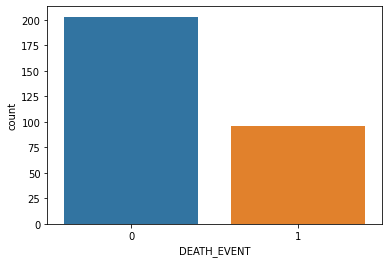

In [130]:
sns.countplot(x = 'DEATH_EVENT', data = data)

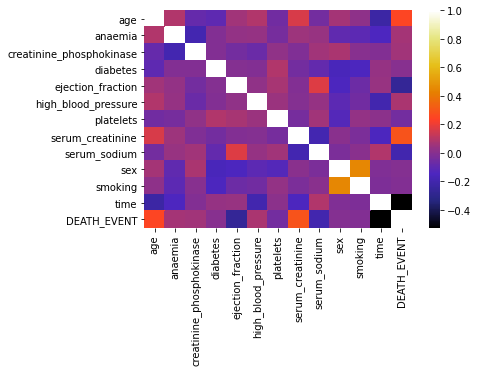

In [131]:
sns.heatmap(data.corr(), cmap="CMRmap")
plt.show() #sacar conclusiones

In [132]:
X_embedded = TSNE(n_components=2).fit_transform(data)

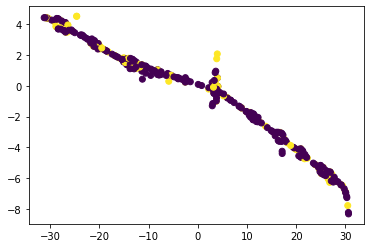

In [133]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=data.DEATH_EVENT)
plt.show() #sacar conlusiones

Pocos outliers 

Distrubución complicada para clasificadores simples

### Data Preparation

In [134]:
class dataset:

  def __init__(self, X: np.array, y: np.array, name: str = "", test_size: int = 15):
    if  not 0 < test_size < 100: 
      raise RuntimeError("Wrong percentage range")
    
    self.name = name
    self.X = X
    self.y = y
    
    self.X_train, self.X_test, self.y_train, self.y_test  = train_test_split(X, y, test_size = test_size/100)

  def split(self) -> tuple:
    return self.X_train, self.X_test, self.y_train, self.y_test

In [135]:
ds_base = dataset(data.values[:, :-1], data.values[:, -1], name = "basic")

mask: list = outlier(ds_base.X)
ds_without_outlier = dataset(ds_base.X[mask, :], ds_base.y[mask], name = "without outlier")

x_aux,y_aux = over_sampling(ds_without_outlier.X, ds_without_outlier.y)
ds_SMOTE = dataset(x_aux, y_aux, name = "SMOTE aumentation")

DATASETS = [
    ds_base,
    ds_without_outlier,
    ds_SMOTE
]

## Modeling

In [136]:
class Model:

  def __init__(self, pipeline: Pipeline):
    self._pipeline = pipeline
    
    self.estimators        = []
    self.name              = " + ".join(pipeline.named_steps.keys())
    self.auc_measure_train = 0
    self.auc_measure_test  = 0

  def train(self, X_train: np.array, y_train: np.array, cv: int = 5) -> float:
    result = cross_validate(
        pipe, 
        X_train, 
        y_train, 
        cv = cv,
        scoring=('roc_auc'),
        return_estimator = True
      )
    
    self.estimators        = result['estimator']
    self.auc_measure_train = np.mean(result['test_score'])

    return self.auc_measure_train                                       

  def evaluate(self, X_test: np.array,  y_test: np.array) -> float:

    for estimator in self.estimators:
      yhat = estimator.predict(X_test)
      self.auc_measure_test += roc_auc_score(y_test, yhat)
    
    self.auc_measure_test /= len(self.estimators)
    return self.auc_measure_test

  def getMeasure(self) -> dict:
    return {
        "AUC_test": self.auc_measure_test,
        "AUC_train": self.auc_measure_train,
        "name": self.name,
        "estimators": self.estimators
    }

In [137]:
class ModelsCollection:

  def __init__(self):
    self.collection = []

  def add(self, item):
     self.collection.append(item)

  def size(self) -> int:
    return len(self.collection)

  def get(self, index: int) -> Model:
    return self.collection[index]

  def chooseTheBest(self, number: int = 3):
    self.collection.sort(
      key = lambda x: x["AUC_test"],
      reverse = True
    )
    return self.collection[0:number]


In [138]:
class ModelsBuilder:

  def _rules(self, t0, t1) -> bool:
    return not (("KBest" in t0) and t1 == "StandardScaler")

  def __init__(self):
    self.combinations = []

    self.combinations = [[clf] for clf in CLASSIFIERS]

    self.combinations[len(self.combinations):] = [
      list(reversed([clf, norm])) 
      for clf in CLASSIFIERS 
      for norm in NORMALIZATION]

    self.combinations[len(self.combinations):] = [
      list(reversed([clf, fe])) 
      for clf in CLASSIFIERS 
      for fe in FEATURE_EXTRACTION]

    self.combinations[len(self.combinations):] = [
      list(reversed([clf, norm, fe]))
      for clf in CLASSIFIERS 
      for norm in NORMALIZATION 
      for fe in FEATURE_EXTRACTION
      if self._rules(fe[0], norm[0])
    ]


  def build(self):
    for pipe in self.combinations:
      yield Pipeline(steps=pipe)

builder = ModelsBuilder()

In [139]:
l = {}
for ds in DATASETS:
  l[ds.name] = ModelsCollection()
  X_train, X_test, y_train, y_test = ds.split()
  print("\n")
  print("#"*10, ds.name.upper(), "DATASET ", "#"*10, "\n")
  index = 0
  for pipe in builder.build():
    model = Model(pipe)
    model.train(X_train, y_train)
    model.evaluate(X_test, y_test)
    l[ds.name].add(model.getMeasure())
    index += 1
  for m in l[ds.name].chooseTheBest():
    print_measure(m)  



########## BASIC DATASET  ########## 

Normalizer + GradientBoostingClassifier
	score_train: 0.892 | score_test: 0.754
KBest - chi k = 6 + Normalizer + RandomForestClassifier
	score_train: 0.901 | score_test: 0.743
SFS k = 6 + RandomForestClassifier
	score_train: 0.937 | score_test: 0.742


########## WITHOUT OUTLIER DATASET  ########## 

KBest - chi k = 6 + Normalizer + AdaBoostClassifier
	score_train: 0.794 | score_test: 0.911
StandardScaler + GradientBoostingClassifier
	score_train: 0.869 | score_test: 0.895
KBest - chi k = 6 + RandomForestClassifier
	score_train: 0.879 | score_test: 0.895


########## SMOTE AUMENTATION DATASET  ########## 

PCA k = 6 + StandardScaler + GradientBoostingClassifier
	score_train: 0.903 | score_test: 0.917
PCA k = 6 + RandomForestClassifier
	score_train: 0.905 | score_test: 0.913
PCA k = 6 + GradientBoostingClassifier
	score_train: 0.903 | score_test: 0.905


## Comparative

In [140]:
def build_comparatie_plots(index: int, curve_data: list, title: str, X_test: np.array, y_test: np.array) -> None:
      plt.figure(index)
      tprs = []
      aucs = []
      mean_fpr = np.linspace(0, 1, 100)

      fig, ax = plt.subplots()
      for i,model in enumerate(curve_data['estimators']):
            viz = plot_roc_curve(model, X_test, y_test,
                              name='ROC fold {}'.format(i),
                              alpha=0.3, lw=1, ax=ax)
            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

      ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

      mean_tpr = np.mean(tprs, axis=0)
      mean_tpr[-1] = 1.0
      mean_auc = curve_data['AUC_test']
      std_auc  = np.std(aucs)
      ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

      std_tpr = np.std(tprs, axis=0)
      tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
      tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
      ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

      ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
            title=title)
      ax.legend(loc="lower right")
      # Here is the trick
      plt.gcf()
      handles, labels = plt.gca().get_legend_handles_labels()
      handles = handles[6:]
      labels = labels[6:]
      by_label = dict(zip(labels, handles))
      plt.legend(by_label.values(), by_label.keys())
      plt.show()

Normalizer + GradientBoostingClassifier
	score_train: 0.892 | score_test: 0.754


<Figure size 432x288 with 0 Axes>

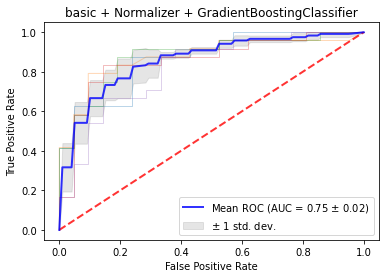

KBest - chi k = 6 + Normalizer + RandomForestClassifier
	score_train: 0.901 | score_test: 0.743


<Figure size 432x288 with 0 Axes>

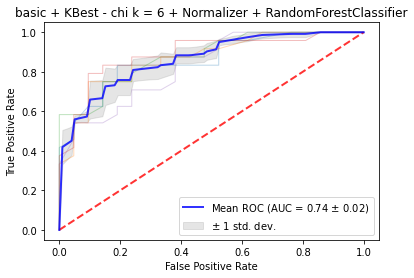

SFS k = 6 + RandomForestClassifier
	score_train: 0.937 | score_test: 0.742


<Figure size 432x288 with 0 Axes>

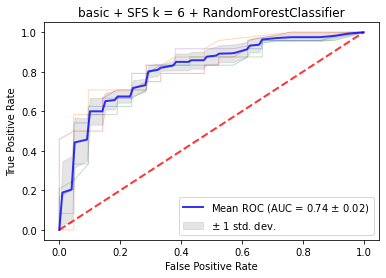

KBest - chi k = 6 + Normalizer + AdaBoostClassifier
	score_train: 0.794 | score_test: 0.911


<Figure size 432x288 with 0 Axes>

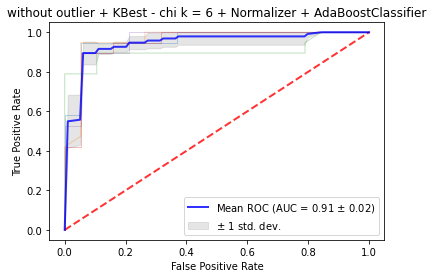

StandardScaler + GradientBoostingClassifier
	score_train: 0.869 | score_test: 0.895


<Figure size 432x288 with 0 Axes>

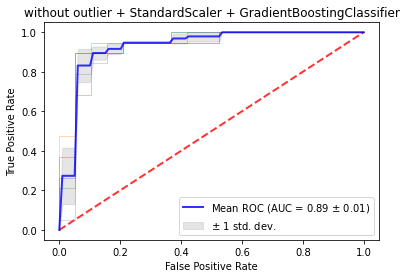

KBest - chi k = 6 + RandomForestClassifier
	score_train: 0.879 | score_test: 0.895


<Figure size 432x288 with 0 Axes>

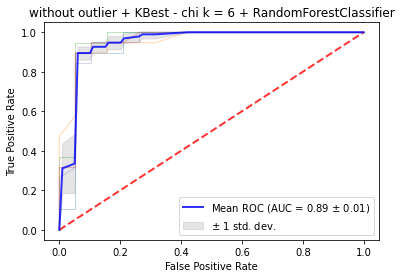

PCA k = 6 + StandardScaler + GradientBoostingClassifier
	score_train: 0.903 | score_test: 0.917


<Figure size 432x288 with 0 Axes>

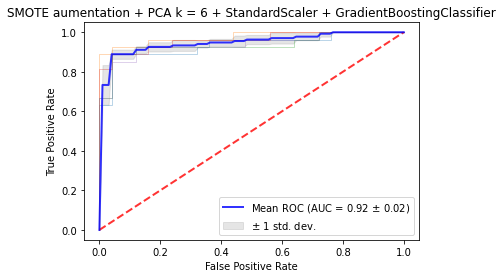

PCA k = 6 + RandomForestClassifier
	score_train: 0.905 | score_test: 0.913


<Figure size 432x288 with 0 Axes>

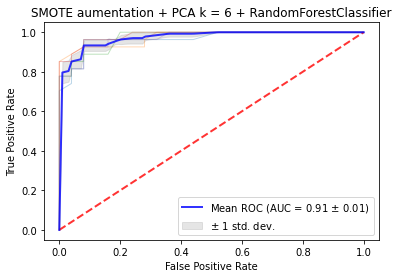

PCA k = 6 + GradientBoostingClassifier
	score_train: 0.903 | score_test: 0.905


<Figure size 432x288 with 0 Axes>

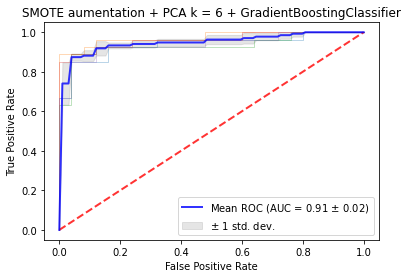

In [142]:
for ds in DATASETS:
    _, X_test, _, y_test = ds.split()
    for index, est in enumerate(l[ds.name].chooseTheBest()):
        print_measure(est)
        build_comparatie_plots(
        index, 
            est, 
            "%s + %s" % (ds.name, est['name']),
            X_test,
            y_test
        )
